In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
import datetime
import statsmodels.api as sm
import torch
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
pre_path = "./data/"

# Load data 


In [4]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    #print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.30770,1.33280,1.30760,1.32910,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.55000,517.85000,511.43000,517.42000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.57000,46729.73000,46210.55000,46650.01000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,3676.01000,3730.00000,3676.01000,3721.67000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
4,2022-01-01 00:00:00,0.45057,0.45797,0.45002,0.45756,3.289705e+07,2022-01-01 00:59:59,1.494042e+07,30227,1.714832e+07,7.788349e+06,0,GALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,2023-11-30 23:00:00,0.26040,0.26210,0.25980,0.26190,1.004176e+07,2023-11-30 23:59:59,2.621476e+06,7398,5.443095e+06,1.421194e+06,0,GMT
165472,2023-11-30 23:00:00,14.31900,14.41000,14.28700,14.40700,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
165473,2023-11-30 23:00:00,0.76070,0.76330,0.75760,0.76260,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
165474,2023-11-30 23:00:00,59.28400,59.30900,58.95300,59.30900,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


# Stationary test

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
results_lp = []
data_df['log_close'] = np.log(data_df['close'])
for coin, grp in data_df.groupby('coin_type'):
    logp = grp['log_close'].dropna()
    adf_res_lp = adfuller(logp)
    results_lp.append({
        'coin_type': coin,
        'adf_statistic_logprice': adf_res_lp[0],
        'p_value_logprice':       adf_res_lp[1],
        'used_lag_logprice':      adf_res_lp[2],
        'n_obs_logprice':         adf_res_lp[3]
    })

df_stationarity_lp = pd.DataFrame(results_lp)
display(df_stationarity_lp)

,coin_type,adf_statistic_logprice,p_value_logprice,used_lag_logprice,n_obs_logprice
0,ADA,-2.471961,0.122446,31,16743
1,BNB,-2.775199,0.061905,39,16639
2,BTC,-1.798967,0.380975,0,16678
3,ETH,-2.643962,0.084247,32,16742
4,GALA,-2.540100,0.106020,44,16682
5,GMT,-1.245533,0.653709,39,14931
6,LINK,-2.275919,0.179852,26,16748
7,MATIC,-2.830012,0.054113,31,16743
8,SOL,-2.409661,0.139028,33,16621
9,XRP,-2.327841,0.163146,31,16623


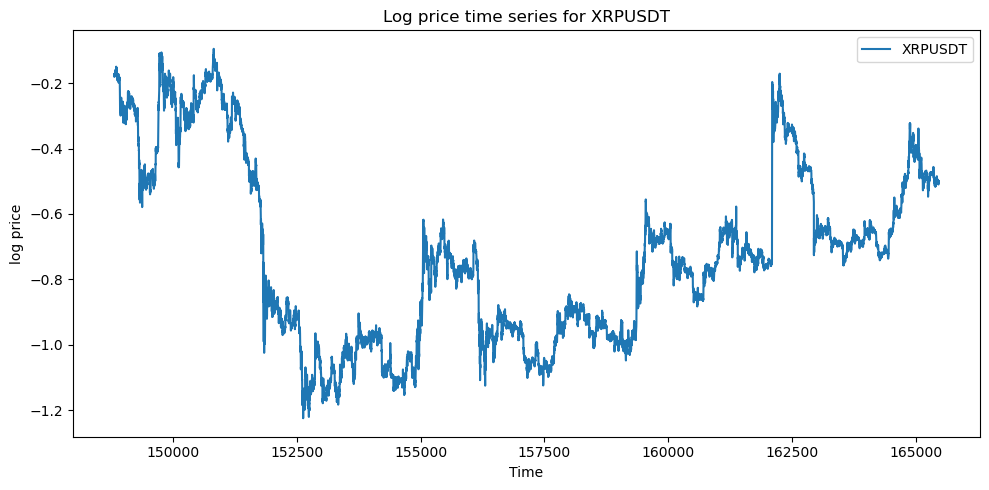

In [25]:
plt.figure(figsize=(10,5))
plt.plot(logp.index,logp.values, label='XRPUSDT')
plt.ylabel("log price")
plt.xlabel("Time")
plt.legend()
plt.title("Log price time series for XRPUSDT")
plt.tight_layout()
plt.show()


In [26]:
results = []
for coin, grp in data_df.groupby('coin_type'):
    returns = grp['return'].dropna()
    # Run ADF test
    adf_res = adfuller(returns)
    results.append({
        'coin_type': coin,
        'adf_statistic': adf_res[0],
        'p_value':       adf_res[1],
        'used_lag':      adf_res[2],
        'n_obs':         adf_res[3]
    })

df_stationarity = pd.DataFrame(results)
display(df_stationarity)


,coin_type,adf_statistic,p_value,used_lag,n_obs
0,ADA,-25.432659,0.000000e+00,30,16744
1,BNB,-21.573747,0.000000e+00,38,16640
2,BTC,-130.116778,0.000000e+00,0,16678
3,ETH,-18.189403,2.421480e-30,44,16730
4,GALA,-18.383406,2.207275e-30,44,16682
5,GMT,-17.368786,5.152325e-30,42,14928
6,LINK,-25.985164,0.000000e+00,25,16749
7,MATIC,-24.319323,0.000000e+00,30,16744
8,SOL,-23.585505,0.000000e+00,32,16622
9,XRP,-25.102087,0.000000e+00,30,16624


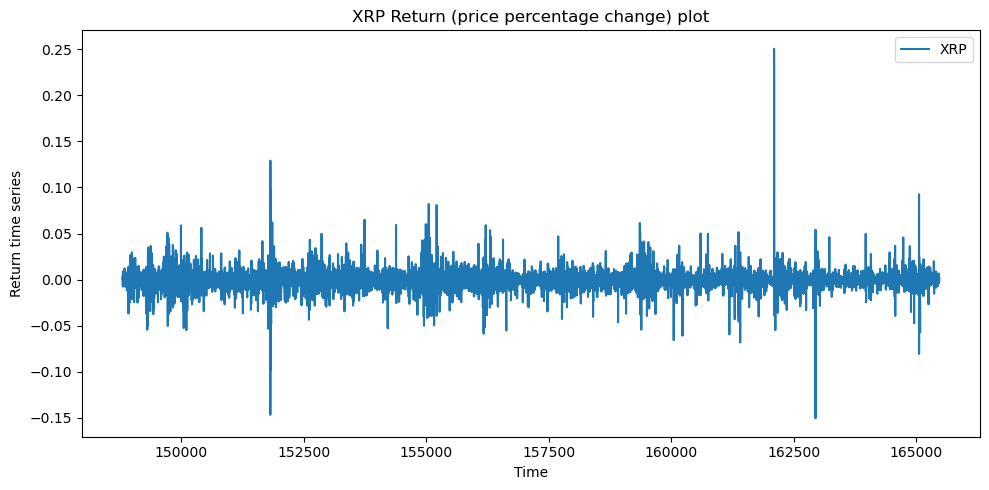

In [27]:
plt.figure(figsize=(10,5))
plt.plot(returns.index,returns.values, label='XRP')
plt.ylabel("Return time series")
plt.xlabel("Time")
plt.legend()
plt.title("XRP Return (price percentage change) plot")
plt.tight_layout()
plt.show()


## Mean-reversion

/tmp/ipykernel_1064825/431870362.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mr1 = df_mr1.groupby('open_time').apply(normalize_weights).reset_index(drop=True)


=== One‐Lag Mean‐Reversion ===
Avg hourly ret = 0.0026%
Std hourly ret = 0.6687%
Ann Sharpe     = 0.37
Final cum PnL  = 1.06


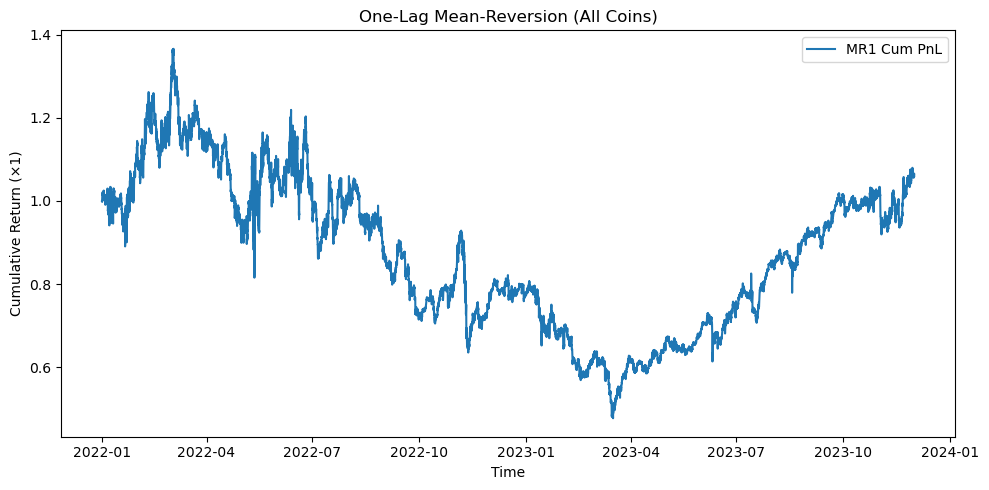

In [37]:
data_df['open_time'] = pd.to_datetime(data_df['open_time'])
# Compute hourly simple return:
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .transform(lambda s: s.pct_change())
)
# Drop NaNs (first row per coin)
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)

# ──────────────────────────────────────────────────────────
# 1) One‐Lag Mean‐Reversion
# ──────────────────────────────────────────────────────────
# 1.1) Lagged return:
data_df['r_lag1'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda x: x.shift(1))
)
# 1.2) Signal = -sign(r_lag1)
data_df['signal_mr1'] = data_df['r_lag1'].apply(lambda x: -np.sign(x) if pd.notna(x) else 0)

# 1.3) Normalize weights per hour:
def normalize_weights(df):
    nonzero = (df['signal_mr1'] != 0).sum()
    out = df.copy()
    if nonzero > 0:
        out['weight_mr1'] = df['signal_mr1'] / nonzero
    else:
        out['weight_mr1'] = 0.0
    return out

df_mr1 = data_df.copy().reset_index(drop=True)
df_mr1 = df_mr1.groupby('open_time').apply(normalize_weights).reset_index(drop=True)

# 1.4) P&L = weight * return
df_mr1['pnl_mr1'] = df_mr1['weight_mr1'] * df_mr1['return']

# 1.5) Aggregate to get portfolio P&L per hour
backtest_mr1 = (
    df_mr1
    .groupby('open_time')['pnl_mr1']
    .sum()
    .reset_index(name='pnl_mr1')
)
backtest_mr1 = backtest_mr1.dropna(subset=['pnl_mr1']).reset_index(drop=True)

# 1.6) Stats for MR1
avg_ret_mr1   = backtest_mr1['pnl_mr1'].mean()
std_ret_mr1   = backtest_mr1['pnl_mr1'].std(ddof=0)
ann_sharpe_mr1 = (avg_ret_mr1 / std_ret_mr1) * np.sqrt(8760)
backtest_mr1['cum_pnl_mr1'] = (1 + backtest_mr1['pnl_mr1']).cumprod()

print("=== One‐Lag Mean‐Reversion ===")
print(f"Avg hourly ret = {avg_ret_mr1:.4%}")
print(f"Std hourly ret = {std_ret_mr1:.4%}")
print(f"Ann Sharpe     = {ann_sharpe_mr1:.2f}")
print(f"Final cum PnL  = {backtest_mr1['cum_pnl_mr1'].iloc[-1]:.2f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(backtest_mr1['open_time'], backtest_mr1['cum_pnl_mr1'], label='MR1 Cum PnL')
plt.title('One‐Lag Mean‐Reversion (All Coins)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (×1)')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1064825/1206053214.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extreme = df_extreme.groupby('open_time').apply(tag_extremes).reset_index(drop=True)
/tmp/ipykernel_1064825/1206053214.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extreme = df_extreme.groupby('open_time').apply(assign_weights).reset_index(drop=True)


=== “Rank‐and‐Trade” Extreme Z‐Score Mean‐Reversion ===
Average hourly return  = 0.0006%
Std dev of hourly ret  = 0.0826%
Annualized Sharpe      = 0.74
Final cumulative P&L   = 1.11


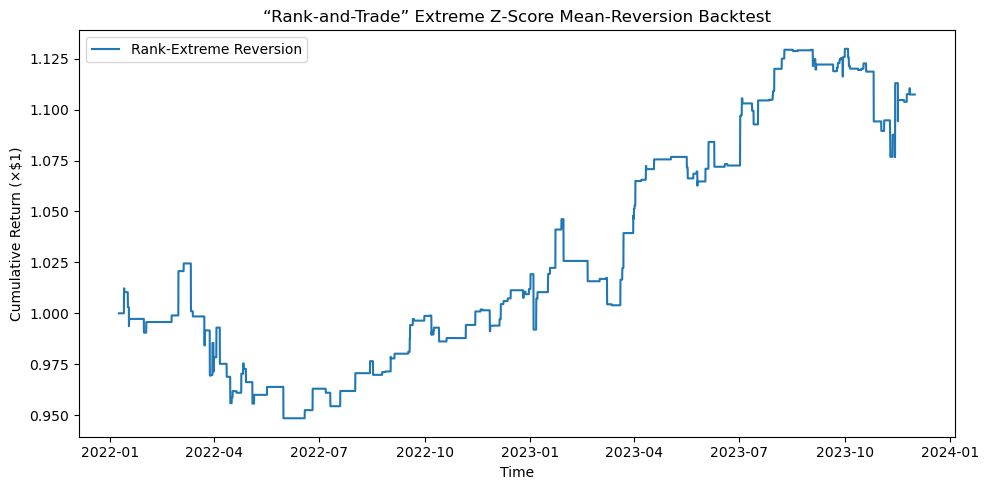

In [51]:
# 1) Compute simple hourly return per coin:
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .transform(lambda s: s.pct_change())
)

# 2) Drop the first NaN‐return for each coin
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# B) COMPUTE ROLLING STD (σ_{i,t-1}) and LAGGED return (r_{i,t-1})
# ──────────────────────────────────────────────────────────
L = 24     # look‐back window for rolling‐sigma
theta = 1.5  # z‐score threshold

# 1) Rolling‐window mean and std of returns (we only really need std since mean ~ 0)
data_df['r_std_L'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda r: r.rolling(window=L, min_periods=L).std())
)

# 2) Lag those stats by one hour, so that at time t we only use info up to t−1
data_df['r_std_L_lag1'] = (
    data_df
    .groupby('coin_type')['r_std_L']
    .transform(lambda s: s.shift(1))
)

# 3) Lagged return itself
data_df['r_lag1'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda s: s.shift(1))
)

# 4) Compute z‐score of the last hour’s return, using σ_{t-1}:
data_df['z_lag1'] = data_df['r_lag1'] / data_df['r_std_L_lag1']

# 5) We’ll drop any row where σ_{t-1} is NaN (i.e. we don’t have a full L‐hour history yet)
data_df = data_df.dropna(subset=['r_std_L_lag1']).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# C) TAG “MOST EXTREME” COINS AND BUILD LONG/SHORT SIGNALS
# ──────────────────────────────────────────────────────────

df_extreme = data_df[['open_time','coin_type','z_lag1','return']].copy()

# Initialize columns for “is_long_extreme” and “is_short_extreme”
df_extreme['is_long_extreme']  = 0
df_extreme['is_short_extreme'] = 0

def tag_extremes(group):
    """
    Input: group = all coins at a fixed open_time t
    We find the coin with the minimum z_lag1 and the coin with the maximum z_lag1.
    If z_min < -theta AND z_max > +theta, we set:
       is_long_extreme  = 1  for the coin that has z_min,
       is_short_extreme = 1  for the coin that has z_max.
    Otherwise, we leave both as 0 (no trade).
    """
    # 1) Identify index of smallest and largest z_lag1
    idx_min = group['z_lag1'].idxmin()
    idx_max = group['z_lag1'].idxmax()

    z_min = group.loc[idx_min, 'z_lag1']
    z_max = group.loc[idx_max, 'z_lag1']

    # 2) Check thresholds
    if (z_min < -theta) and (z_max > +theta):
        group.at[idx_min, 'is_long_extreme']  = 1
        group.at[idx_max, 'is_short_extreme'] = 1
    # else: leave both at 0 (no trade)

    return group

# Apply per open_time
df_extreme = df_extreme.groupby('open_time').apply(tag_extremes).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# D) ASSIGN WEIGHTS AND COMPUTE NEXT‐HOUR P&L
# ──────────────────────────────────────────────────────────

# 1) Create a column for weight_extreme; default to 0
df_extreme['weight_extreme'] = 0.0

def assign_weights(group):
    """
    At each open_time, group will have ten rows (one per coin).
    Exactly one row may have is_long_extreme=1, 
    exactly one row may have is_short_extreme=1 (or both zero).
    We assign weight +0.5 to the long coin, -0.5 to the short coin.
    If no signals, all weights = 0.
    """
    # Find how many longs and shorts:
    n_long  = (group['is_long_extreme']  == 1).sum()
    n_short = (group['is_short_extreme'] == 1).sum()

    # If exactly one long and one short, assign 0.5 and -0.5:
    if (n_long == 1) and (n_short == 1):
        group.loc[group['is_long_extreme'] == 1,  'weight_extreme'] = +0.5
        group.loc[group['is_short_extreme'] == 1, 'weight_extreme'] = -0.5
    else:
        # no trade or incomplete signal → all zeros
        group['weight_extreme'] = 0.0

    return group

df_extreme = df_extreme.groupby('open_time').apply(assign_weights).reset_index(drop=True)

# 2) Compute the P&L at time t as: weight_extreme * return_{i,t}
#    Because we enter at t (based on last‐hour’s z) and exit at t+1, using "return" 
#    is appropriate if return_{i,t} = (P_{i,t}/P_{i,t-1}) - 1. 
#    In our load, data_df['return'] is indeed that.
df_extreme['pnl_extreme'] = df_extreme['weight_extreme'] * df_extreme['return']

# 3) Collapse to get one P&L per open_time
backtest_extreme = (
    df_extreme
    .groupby('open_time')['pnl_extreme']
    .sum()
    .reset_index(name='pnl_extreme')
).dropna(subset=['pnl_extreme']).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# E) SUMMARY STATS & PLOT
# ──────────────────────────────────────────────────────────
avg_ret_extreme = backtest_extreme['pnl_extreme'].mean()
std_ret_extreme = backtest_extreme['pnl_extreme'].std(ddof=0)
ann_sharpe_extreme = (avg_ret_extreme / std_ret_extreme) * np.sqrt(8760)
backtest_extreme['cum_pnl_extreme'] = (1 + backtest_extreme['pnl_extreme']).cumprod()

print("=== “Rank‐and‐Trade” Extreme Z‐Score Mean‐Reversion ===")
# print(f"Threshold (θ)          = {theta}")
# print(f"Look‐back window (L)   = {L} hours")
print(f"Average hourly return  = {avg_ret_extreme:.4%}")
print(f"Std dev of hourly ret  = {std_ret_extreme:.4%}")
print(f"Annualized Sharpe      = {ann_sharpe_extreme:.2f}")
print(f"Final cumulative P&L   = {backtest_extreme['cum_pnl_extreme'].iloc[-1]:.2f}")

# Plot cumulative curve
plt.figure(figsize=(10,5))
plt.plot(backtest_extreme['open_time'], backtest_extreme['cum_pnl_extreme'], label='Rank‐Extreme Reversion')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (×$1)')
plt.title('“Rank‐and‐Trade” Extreme Z‐Score Mean‐Reversion Backtest')
plt.legend()
plt.tight_layout()
plt.show()

# Cointegration test

In [28]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## CADF test

In [29]:
price_df = data_df.pivot(index='open_time', columns='coin_type', values='close')

# 2) Identify all unique pairs of coins
coins = price_df.columns.tolist()
pairs = []
for i in range(len(coins)):
    for j in range(i+1, len(coins)):
        pairs.append((coins[i], coins[j]))

# 3) For each pair, run Engle-Granger (CADF) test and record ADF p-value
results = []
for coin1, coin2 in pairs:
    pair_df = price_df[[coin1, coin2]].dropna()
    if len(pair_df) < 50:
        # Not enough data points
        continue

    # OLS regression: coin1 ~ coin2
    y = pair_df[coin1]
    x = pair_df[coin2]
    x_const = sm.add_constant(x)
    ols_res = sm.OLS(y, x_const).fit()
    beta_hat = ols_res.params[coin2]
    resid = ols_res.resid

    # ADF on residuals
    adf_stat, adf_pval, _, _, crit_vals, _ = adfuller(resid.dropna())
    results.append({
        "pair" : f"{coin1}-{coin2}",
        'coin1': coin1,
        'coin2': coin2,
        'beta_hat': beta_hat,
        'adf_stat': adf_stat,
        'adf_pval': adf_pval,
        'crit_1%': crit_vals['1%'],
        'crit_5%': crit_vals['5%'],
        'crit_10%': crit_vals['10%']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('adf_pval')
results_df = results_df.reset_index(drop=True)

In [30]:
results_df[:3]

,pair,coin1,coin2,beta_hat,adf_stat,adf_pval,crit_1%,crit_5%,crit_10%
0,GALA-GMT,GALA,GMT,0.059660,-5.646766,0.000001,-3.430789,-2.861734,-2.566873
1,ADA-GALA,ADA,GALA,3.023319,-5.468280,0.000002,-3.430742,-2.861713,-2.566862
2,ADA-GMT,ADA,GMT,0.231038,-4.021515,0.001302,-3.430788,-2.861734,-2.566873


Top cointegrated pair: GALA & GMT (ADF p-value = 0.0000)


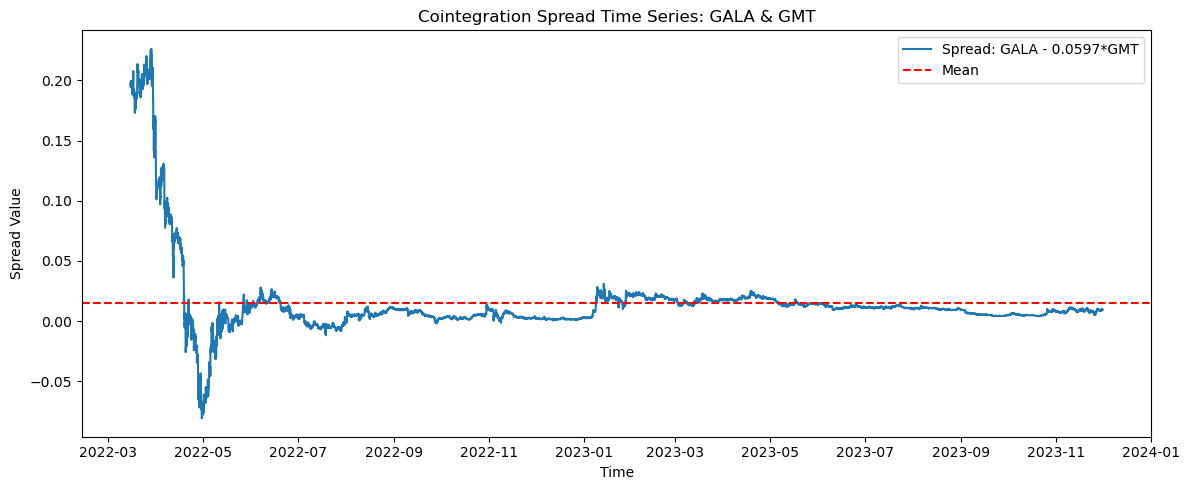

In [31]:
best_pair = results_df.iloc[0]
coin1 = best_pair['coin1']
coin2 = best_pair['coin2']
beta_hat = best_pair['beta_hat']
best_pval = best_pair['adf_pval']

print(f"Top cointegrated pair: {coin1} & {coin2} (ADF p-value = {best_pval:.4f})")

# 5) Compute the spread: S_t = Y_t - beta_hat * X_t
pair_df = price_df[[coin1, coin2]].dropna()
spread = pair_df[coin1] - beta_hat * pair_df[coin2]

# 6) Plot the spread time series
plt.figure(figsize=(12, 5))
plt.plot(spread.index, spread.values, label=f"Spread: {coin1} - {beta_hat:.4f}*{coin2}")
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel("Time")
plt.ylabel("Spread Value")
plt.title(f"Cointegration Spread Time Series: {coin1} & {coin2}")
plt.legend()
plt.tight_layout()
plt.show()

## Johansen’s test

In [32]:
coins = price_df.columns.tolist()
pairs = []
for i in range(len(coins)):
    for j in range(i+1, len(coins)):
        pairs.append((coins[i], coins[j]))

# 3) For each pair, run Johansen’s test and record the “trace statistic minus 95% critical value” for r=0
joh_results = []
for coin1, coin2 in pairs:
    pair_df = price_df[[coin1, coin2]].dropna()
    if len(pair_df) < 50:
        continue
    
    # Perform Johansen test (det_order=0, k_ar_diff=1)
    jres = coint_johansen(pair_df.values, det_order=0, k_ar_diff=1)
    trace_stat_0 = jres.lr1[0]            # Trace statistic for r=0
    crit_95_0 = jres.cvt[0, 1]            # 95% critical value for r=0
    margin = trace_stat_0 - crit_95_0     # how much trace exceeds critical
    
    joh_results.append({
        'coin1': coin1,
        'coin2': coin2,
        'trace_stat_0': trace_stat_0,
        'crit_95_0': crit_95_0,
        'margin': margin,
        'eigvec_b1': jres.evec[0, 0],
        'eigvec_b2': jres.evec[1, 0]
    })

joh_df = pd.DataFrame(joh_results)

Top Johansen cointegrated pair: GALA & GMT (margin = 68.4966)


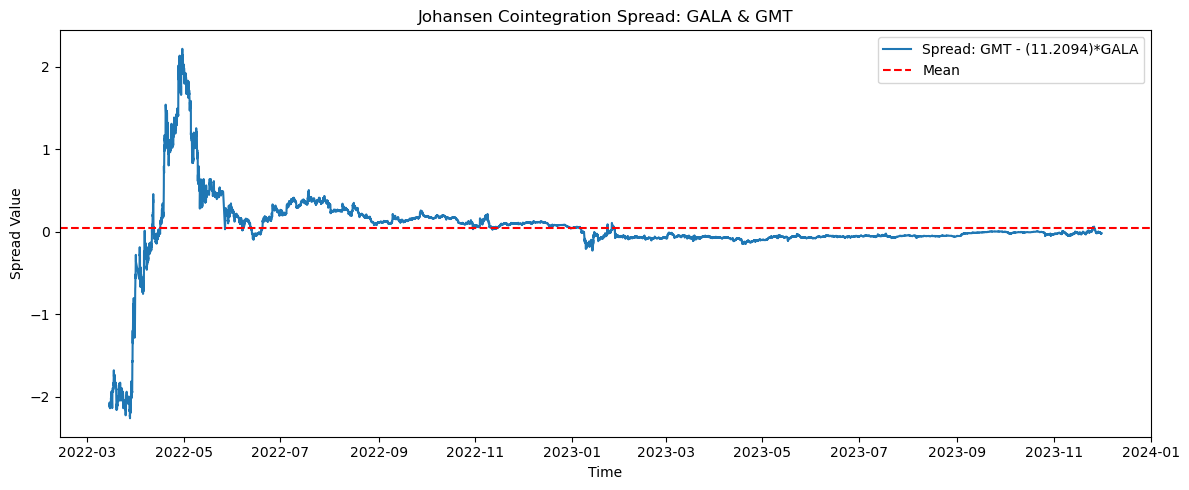

In [33]:
best_joh_row = joh_df.loc[joh_df['margin'].idxmax()]
coin1 = best_joh_row['coin1']
coin2 = best_joh_row['coin2']
b1 = best_joh_row['eigvec_b1']
b2 = best_joh_row['eigvec_b2']
margin = best_joh_row['margin']

print(f"Top Johansen cointegrated pair: {coin1} & {coin2} (margin = {margin:.4f})")

# 5) Compute the spread: if eigenvector is [b1, b2], coin2 = -(b1/b2)*coin1
alpha = -b1 / b2
pair_df = price_df[[coin1, coin2]].dropna()
spread = pair_df[coin2] - alpha * pair_df[coin1]

# 6) Plot the spread time series
plt.figure(figsize=(12, 5))
plt.plot(spread.index, spread.values, label=f"Spread: {coin2} - ({alpha:.4f})*{coin1}")
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel("Time")
plt.ylabel("Spread Value")
plt.title(f"Johansen Cointegration Spread: {coin1} & {coin2}")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
joh_df = joh_df.sort_values('margin',ascending=False)
joh_df = joh_df.reset_index(drop=True)
joh_df[:3]

,coin1,coin2,trace_stat_0,crit_95_0,margin,eigvec_b1,eigvec_b2
0,GALA,GMT,83.990854,15.4943,68.496554,25.633936,-2.286821
1,ADA,GMT,58.039788,15.4943,42.545488,8.203502,-2.476805
2,ADA,GALA,56.609590,15.4943,41.115290,9.942601,-37.705094


## Mean reversion strategy

In [35]:
top3 = results_df.head(3).reset_index(drop=True)
start_date = pd.to_datetime("2022-06-01 00:00:00")
df_post_june = data_df[data_df['open_time'] >= start_date].copy()
price_df_post_june = df_post_june.pivot(index='open_time', columns='coin_type', values='close')



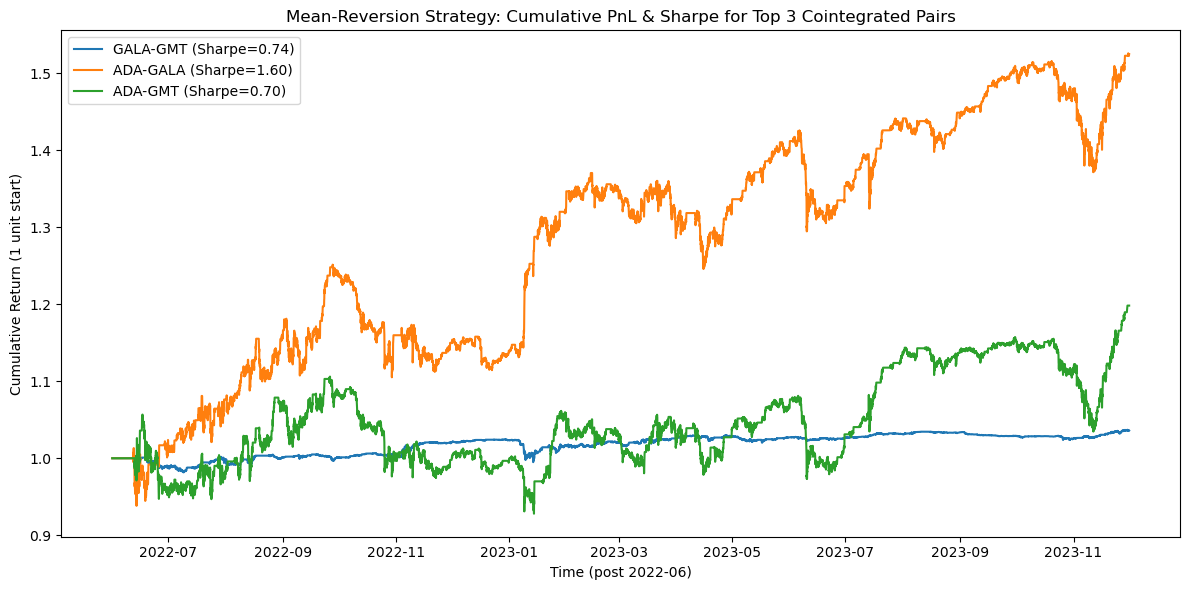

Sharpe Ratios for Top 3 Pairs:
GALA-GMT: 0.74
ADA-GALA: 1.60
ADA-GMT: 0.70


In [36]:
coins = price_df_post_june.columns.tolist()
pairs = [(coins[i], coins[j]) for i in range(len(coins)) for j in range(i+1, len(coins))]

results = {}
window = 252  # rolling window of 252 hours (~10.5 days)

for idx, row in top3.iterrows():
    coin1 = row['coin1']
    coin2 = row['coin2']
    beta = row['beta_hat']
    pair_price = price_df_post_june[[coin1, coin2]].dropna()

    # Compute spread S_t = coin1 - beta * coin2
    spread = pair_price[coin1] - beta * pair_price[coin2]

    # Rolling mean and std of spread
    roll_mean = spread.rolling(window=window, min_periods=window).mean()
    roll_std = spread.rolling(window=window, min_periods=window).std()

    # Z-score
    z_score = (spread - roll_mean) / roll_std

    # Generate signals: long spread if z < -1, short if z > 1, exit at z between -0.5 and 0.5
    signal = pd.Series(index=z_score.index, data=0)
    position = 0
    for t in z_score.index:
        zt = z_score.loc[t]
        if position == 0:
            if zt > 1:
                position = -1  # short spread
            elif zt < -1:
                position = 1   # long spread
        elif position == 1 and zt >= 0:
            position = 0
        elif position == -1 and zt <= 0:
            position = 0
        signal.loc[t] = position

    # Compute PnL: PnL_t = position_{t-1} * (S_t - S_{t-1})
    delta_spread = spread.diff()
    pnl = signal.shift(1).fillna(0) * delta_spread
    cum_pnl = (1 + pnl.fillna(0)).cumprod()

    # Compute Sharpe ratio (annualized, 8760 hours)
    avg_ret = pnl.mean()
    std_ret = pnl.std(ddof=0)
    sharpe = (avg_ret / std_ret) * np.sqrt(8760) if std_ret != 0 else np.nan

    results[f"{coin1}-{coin2}"] = {
        'spread': spread,
        'z_score': z_score,
        'signal': signal,
        'pnl': pnl,
        'cum_pnl': cum_pnl,
        'sharpe': sharpe
    }

# 6) Plot cumulative PnL for top 3 pairs and display Sharpe ratios
plt.figure(figsize=(12, 6))
for pair_name, data in results.items():
    plt.plot(data['cum_pnl'].index, data['cum_pnl'].values, label=f"{pair_name} (Sharpe={data['sharpe']:.2f})", linewidth=1.5)
plt.xlabel("Time (post 2022-06)")
plt.ylabel("Cumulative Return (1 unit start)")
plt.title("Mean-Reversion Strategy: Cumulative PnL & Sharpe for Top 3 Cointegrated Pairs")
plt.legend()
plt.tight_layout()
plt.show()

# 7) Print Sharpe ratios
print("Sharpe Ratios for Top 3 Pairs:")
for pair_name, data in results.items():
    print(f"{pair_name}: {data['sharpe']:.2f}")